## CFFI, Ctypes, Cython: The good, the bad and the ugly

## Pycon Israel 2017

## Matti Picus

![The movie poster](https://images-na.ssl-images-amazon.com/images/M/MV5BMTQxNDcyMjE4NF5BMl5BanBnXkFtZTgwNTU4ODE5MDE@._V1_.jpg)

### Why did you bother to show up? There is a lecture about Grumpy next door

Here is what we will do

<p></p>
<details>
<summary>The ``mandel`` image (5 minutes)</summary>  
  
  - Pure python  
  - Pure C  
  - Timing it
</details>  
<p></p>
<details>
<summary>How to mix C and Python (10 minutes)</summary>  
  - Ctypes  
  - Cython  
  - CFFI
</details>  
<p></p>
<details>
<summary>Comparison - which is the good, the bad, and the ugly (10 minutes)</summary>  
  - Boilerplate  
  - Maintenance  
  - Speed
</details>  
Questions

In [2]:
from __future__ import print_function, division
%matplotlib notebook

def mandel(x, y, max_iters, value):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    i = 0
    c = complex(x,y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if (z.real*z.real + z.imag*z.imag) >= 4:
            value[0] = i
            return 0
    value[0] = 255
    return 1


In [3]:
def create_fractal(image, width, height, iters):
    pixel_size_x = 3.0 / width
    pixel_size_y = 2.0 / height
    for y in range(height):
        imag = y * pixel_size_y - 1
        yy = y*width
        for x in range(width):
            real = x * pixel_size_x - 2
            mandel(real, imag, iters, image[yy+x:yy+x+1])



In [13]:
# Pure python
from timeit import default_timer as timer
import numpy as np
from PIL import Image
width = 1500
height = 1000
image = np.zeros(width*height, dtype=np.uint8)
s = timer()
create_fractal(image, width, height, 20)
e = timer()
print('pure python required {:.2f} secs'.format(e - s))
im = Image.frombuffer('L', (width, height), image, 'raw', 'L', 0, 1)
im.save('python_numpy.png')

pure python required 7.57 secs


<IPython.core.display.Javascript object>


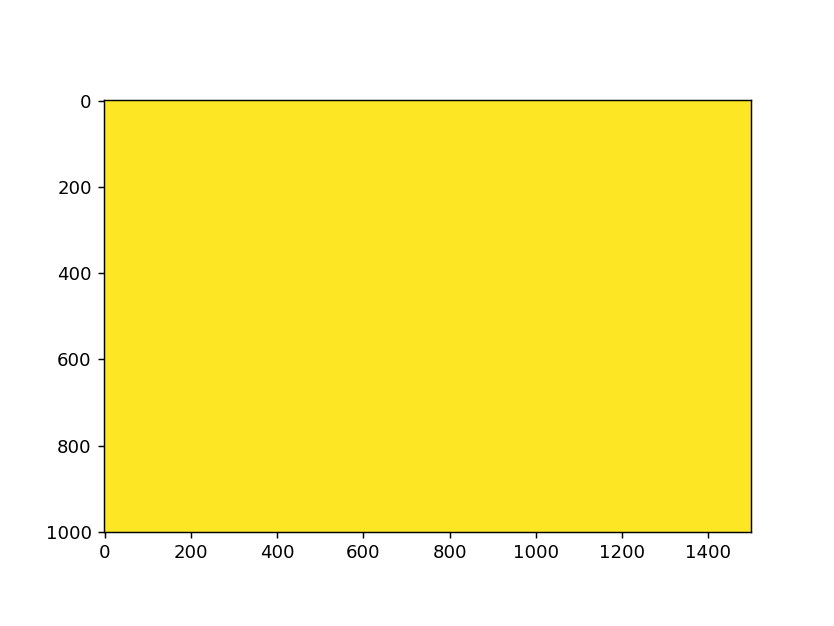

In [14]:
from PIL import Image
from matplotlib.pylab import imshow, show
img = Image.open('python_numpy.png')
imshow(img); show()

In [15]:
%%bash 
cat mandel.c

/* Python
def mandel(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    i = 0
    c = complex(x,y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if (z.real*z.real + z.imag*z.imag) >= 4:
            return i

    return 255
*/

#include <complex.h>

int mandel(int x, int y, int max_iters, unsigned int * val)
{
    int i = 0;
    _Complex float c = CMPLX(x, y);
    _Complex float z = CMPLX(0, 0);
    for (i = 0; i < max_iters; i++)
    {
        z = z * z + c;
        if ((crealf(z) * crealf(z) + cimagf(z) * cimagf(z)) >= 4)
        {
            *val = i;
            return 0;
        }
    }
    *val = 255;
    return 1;
}


In [16]:
%%bash 
cat create_fractal.c

int mandel(int x, int y, int max_iters, unsigned int * val);

void create_fractal(unsigned int * image, int width, int height, 
                    int iters) {
    float pixel_size_x = 3.0 / width;
    float pixel_size_y = 2.0 / height;
    for (int y=0; y<height; y++) {
        float imag = y * pixel_size_y - 1;
        int yy = y * width;
        for (int x=0; x<width; x++) {
            float real = x * pixel_size_x - 2;
            unsigned int color;
            int ret = mandel(real, imag, iters, &color);
            image[yy + x] = color;
        }
    }
}


In [17]:
%%bash
cat main.c

#include <stdio.h>
#include <pgm.h>
#include <time.h>

// call this function to start a nanosecond-resolution timer
struct timespec timer_start(){
    struct timespec start_time;
    clock_gettime(CLOCK_PROCESS_CPUTIME_ID, &start_time);
    return start_time;
}

// call this function to end a timer, returning nanoseconds elapsed as a long
long timer_end(struct timespec start_time){
    struct timespec end_time;
    clock_gettime(CLOCK_PROCESS_CPUTIME_ID, &end_time);
    long diffInNanos = end_time.tv_nsec - start_time.tv_nsec;
    return diffInNanos;
}

int mandel(int x, int y, int max_iters, unsigned int * val);

void create_fractal(unsigned int * image, int width, int height, 
                    int iters);

int main(int argc, const char *argv[], const char * env[])
{
    int width = 1500;
    int height = 1000;
    int iters = 20;
    FILE * fid = NULL;
    struct timespec vartime;
    long time_elapsed_nanos;
    unsigned int * image = (unsigned int*)malloc(width * height * sizeof

In [18]:
%%bash
gcc -O3 mandel.c create_fractal.c main.c -lnetpbm -o create_fractal
time ./create_fractal

create_fractal required 484 millisecs



real	0m0.498s
user	0m0.496s
sys	0m0.000s


In [19]:
from PIL import Image
from matplotlib.pylab import imshow, show
img = Image.open('c.pgm')
imshow(img); show()

In [20]:
# Compare the images
from PIL import Image
import numpy as np
pyimg = np.array(Image.open('python_numpy.png'))
cimg = np.array(Image.open('c.pgm'))
print('max', np.abs(pyimg - cimg).max() )


max 255
